# Hydrological Modeling 

In [1]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import psutil
import pydaymet as daymet
import pygmo as pg
from hymod import HYMOD, compute_kge
from pygeohydro import NWIS
from pynhd import NLDI

We use HyRiver packages to get the required input data for hydrological modeling of a watershed. We use [PyDaymet](https://github.com/cheginit/pydaymet) to get precipitation and potential evapotranspiration and PyGeoHydro to get streamflow observations. Then, we use an implementation of the [HYMOD](https://piahs.copernicus.org/articles/368/180/2015/piahs-368-180-2015.pdf) model for our watershed analysis. The source for the model can be found in `hymod.py` file.

First, we use [PyNHD](https://github.com/cheginit/pynhd) to get the watershed geometry of a NWIS station with the ID of `USGS-01031500`:

In [2]:
station = "08075000"
dates = ("2003-01-01", "2011-12-31")
basin = NLDI().get_basins(station)

Let's check the area of the watershed in sqkm.

In [3]:
basin.to_crs(basin.estimate_utm_crs()).area * 1e-6

identifier
08075000    330.340467
dtype: float64

Now, we get some information about this station and then streamflow observations for calibrating the model from PyGeoHydro. We use the `mmd` flag to return the results in mm/day instead of the default cms.

In [4]:
nwis = NWIS()
info = nwis.get_info({"site": station})
info

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,drain_sqkm,hcdn_2009
0,USGS,08075000,"Brays Bayou at Houston, TX",ST,29.697175,-95.412162,F,NAD83,0.0,0.01,NAVD88,12040104,261.5814,False


In [5]:
qobs = nwis.get_streamflow(station, dates, mmd=True)

PyDaymet can compute Potential EvapoTranspiration (PET) at daily timescale using three methods: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's use `hargreaves_samani` and get the data for 10 years.

In [6]:
clm = daymet.get_bygeom(basin.geometry[0], dates, variables="prcp", pet="hargreaves_samani")

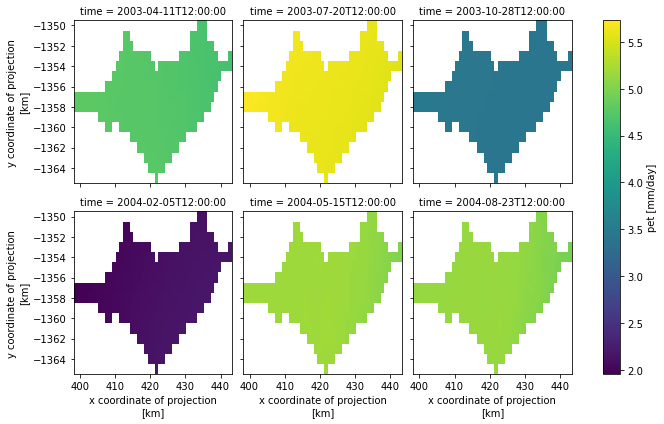

In [7]:
clm.pet.isel(time=range(100, 700, 100)).plot(x="x", y="y", row="time", col_wrap=3)

Since this HYMOD implementation is a lumped model, we need to take areal average of the precipitation and potential evapotranspiration. Moreover, since Daymet's calendar doesn't have leap years and all years are 365 days, we need to make sure that the time index of the input streamflow observation matches that of the climate data.

In [8]:
clm_df = clm.mean(dim=["x", "y"])[["prcp", "pet"]].to_dataframe()
clm_df.index = pd.to_datetime(clm_df.index.date)

qobs.index = pd.to_datetime(qobs.index.to_series().dt.tz_localize(None).dt.date)
idx = qobs.index.intersection(clm_df.index)
qobs, clm_df = qobs.loc[idx], clm_df.loc[idx]

Now, let's use [pygmo](https://esa.github.io/pygmo2/index.html) to calibrate the model parameters using 70% of the observation data.

In [9]:
param_bounds = OrderedDict(
    [
        ("c_max", (1, 100)),
        ("b_exp", (0.0, 2)),
        ("alpha", (0.2, 0.99)),
        ("k_s", (0.01, 0.5)),
        ("k_q", (0.5, 1.2)),
    ]
)
warm_up = 1  # year
cal_idx = int(0.7 * clm_df.shape[0])  # 70% of data for calibration
bounds = list(zip(*param_bounds.values()))

udp = HYMOD(clm_df.iloc[:cal_idx], qobs.iloc[:cal_idx], bounds, 1)
prob = pg.problem(udp)
n_procs = psutil.cpu_count(logical=False)
pop_size = 100
algo = pg.algorithm(pg.sade(gen=int(pop_size / n_procs)))
archi = pg.archipelago(
    n=n_procs,
    algo=algo,
    prob=prob,
    pop_size=pop_size,
)
archi.evolve()
archi.wait_check()
_, vectors, fits = zip(*archi.get_migrants_db())
params = vectors[np.argmin(fits)].squeeze()

With the obtained calibrated parameters, we can validate the model over the validation period (30%) of the streamflow observation.

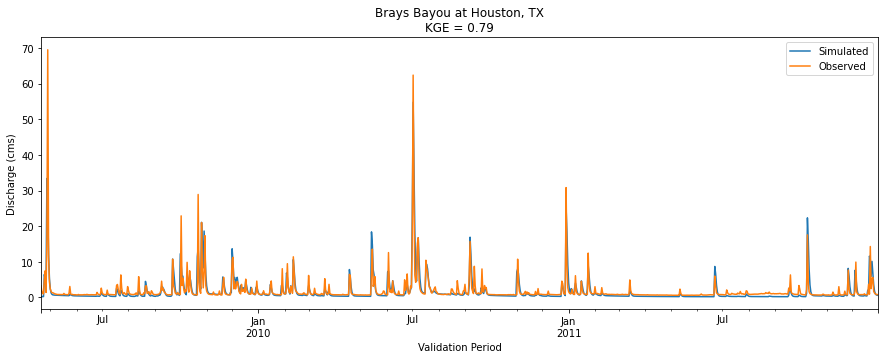

In [10]:
sim = udp.simulate(*clm_df.iloc[cal_idx:].to_numpy("f8").T, *tuple(params))
obs = qobs.iloc[cal_idx:][f"USGS-{station}"].to_numpy()
kge = compute_kge(obs, sim)
name = info.station_nm.values[0]
index = qobs.iloc[cal_idx:].index
discharge = pd.DataFrame({"Simulated": sim, "Observed": obs}, index=index)
_ = discharge.plot(
    figsize=(15, 5),
    xlabel="Validation Period",
    ylabel="Discharge (cms)",
    title=f"{name}\nKGE = {kge:.2f}",
)